In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler


# Load Data

In [477]:
data_path = 'C:/Users/ticom/VLabs/Data'
df = pd.read_csv(data_path+'/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
# df = pd.read_csv('https://raw.githubusercontent.com/marcos-mansur/vlabs-challenge/main/Data/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
df_sub = pd.read_csv(data_path+'/sample_submission.csv',header=0)

# Functions

## Plot curva de aprendizado

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot: learning curve

    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    # plot intervalos de spread 
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    # curvas
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

In [101]:
def split_per_dates(df,train_start,target_start, sub_start):
    # target do treinamento
    df_target = df[df.DT_VENDA > target_start]
    y_train = df_target.groupby('ID_CLIENTE')['VALOR'].sum()
    # dados de treinamento
    df_train = df[(df['DT_VENDA']>train_start) & (df['DT_VENDA']<target_start)].copy()
    # dados para previsão
    df_test = df[df['DT_VENDA']>sub_start]
    return df_train, y_train, df_test

In [490]:
def treated_data(df_pp):
    " transforma o dataset aberto por compras ordenado no tempo "
    " em um dataset por cliente para a previsão"
    
    # intervalos de tempo
    delta90 = pd.to_timedelta(90,unit='d')
    delta120 = pd.to_timedelta(120,unit='d')
    delta150 = pd.to_timedelta(150,unit='d')
    delta180 = pd.to_timedelta(180,unit='d')
    delta360 = pd.to_timedelta(360,unit='d')
    delta270 = pd.to_timedelta(270,unit='d')

    DICT_AUX_DATAS = {'90':delta90,
                      '120':delta120,
                      '150':delta150,
                      '180':delta180}

    max_date = df_pp['DT_VENDA'].max()
    
    #agrupar por cliente somando o valor
    cust_revenue = df_pp.groupby(['ID_CLIENTE'])['VALOR'].sum().copy()
    # transformar em df
    cust_rev = pd.DataFrame(cust_revenue)
    # feature com número de compras feitas no período de teste
    cust_rev['Frequency'] = df_pp.groupby(['ID_CLIENTE'])['ID_VENDA'].count()
    
    
    # std entre os valores das compras de cada cliente
    #cust_rev['std entre compras'] = df_pp.groupby('ID_CLIENTE')['VALOR'].std()
    # diferença entre a data da primeira e ultima compra
    #cust_rev['periodo_compras'] = df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max() - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].min()
    #cust_rev['periodo_compras'] = cust_rev['periodo_compras'].apply(lambda x: x.days)

    # meadia entre os valores das compras de cada cliente
    #cust_rev['Qtd_canais'] = df_pp.groupby(['ID_CLIENTE'])['CANAL'].apply(count_lista)
    #cust_rev['Qtd_loja'] = df_pp.groupby(['ID_CLIENTE'])['LOJA'].apply(count_lista)
    cust_rev['valor medio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].mean()
    cust_rev['valor mediana'] = df_pp.groupby('ID_CLIENTE')['VALOR'].median()
    cust_rev['valor desvio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].std()
    
    
    # data da ultima compra
    cust_rev['Recency'] = max_date - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max()
    cust_rev['Recency'] = cust_rev['Recency'].apply(lambda x: x.days)
    # soma do VALOR dos ultimos 3 meses de cada cliente
    
    
    for item, valor in DICT_AUX_DATAS.items():
        cust_rev[f'valor_{item}m'] = df_pp[
              df_pp['DT_VENDA']>(df_pp['DT_VENDA'].max() - valor)].groupby(['ID_CLIENTE'])['VALOR'].sum()
        cust_rev[f'valormedio_{item}m'] = df_pp[
              df_pp['DT_VENDA']>(df_pp['DT_VENDA'].max() - valor)].groupby(['ID_CLIENTE'])['VALOR'].mean()

  
    ref = df_pp['DT_VENDA'].max()
    cust_rev[f'valorsum_1ano_atras_m'] = df_pp[
            (df_pp['DT_VENDA'] < (ref - delta270) ) &
           (df_pp['DT_VENDA'] > (ref - delta360) )
            ].groupby(['ID_CLIENTE'])['VALOR'].sum()
            
    return cust_rev.fillna(0)

def transform_df(df):
    df = df.copy()
    
    # divide os dados de treino e previsão pela data
    df_train, target_train, df_test = split_per_dates(df,train_start,target_start,sub_start)
    # modifica o df e cria features nos dados de treino
    df_train1 = treated_data(df_train)
    # para alinhar o index do target do treino com os dados de treino
    df_train2 = df_train1.join(other=target_train, on='ID_CLIENTE', lsuffix='_sum', rsuffix='_TARGET')
    x_train = df_train2.drop('VALOR_TARGET',axis=1)
    y_train = df_train2.VALOR_TARGET.fillna(0)
    
    # modifica o df e cria features nos dados de test
    x_test = treated_data(df_test)
    return x_train, y_train, x_test


# Estratégia

In [498]:
# intervalo de 90 dias
delta90 = pd.to_timedelta(90,unit='d')
# data mais recente do dataset
max_date = df['DT_VENDA'].max()
# data de início do target
target_start = max_date - delta90
# data de início dos dados de treino
train_start = target_start - 5*delta90
# data de início dos dados de previsão (submissão)
sub_start = max_date - 5*delta90

# Preprocessing

In [491]:
x_train_total, y_train_total, x_test = transform_df(df)

In [493]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train_total, 
                                                                            y_train_total, 
                                                                            random_state=0,
                                                                            test_size=0.3)

# Model

In [494]:
en = ElasticNet(random_state=0)
en.fit(x_train_split, y_train_split)
en_pred = en.predict(x_test_split)

In [499]:
# validação direta
score_dir = mean_squared_error(y_test_split,en_pred, squared=False)
print('Validação direta RMSE: ',score_dir)

Validação direta RMSE:  242.17955974579024


In [500]:
# validação cruzada
score = cross_val_score(en, X=x_train_total, y=y_train_total, cv=5, scoring='neg_root_mean_squared_error')
print('RMSE: ',-score.mean(), '\nstd = :', score.std())

RMSE:  245.95534755944885 
std = : 17.35234633398839


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

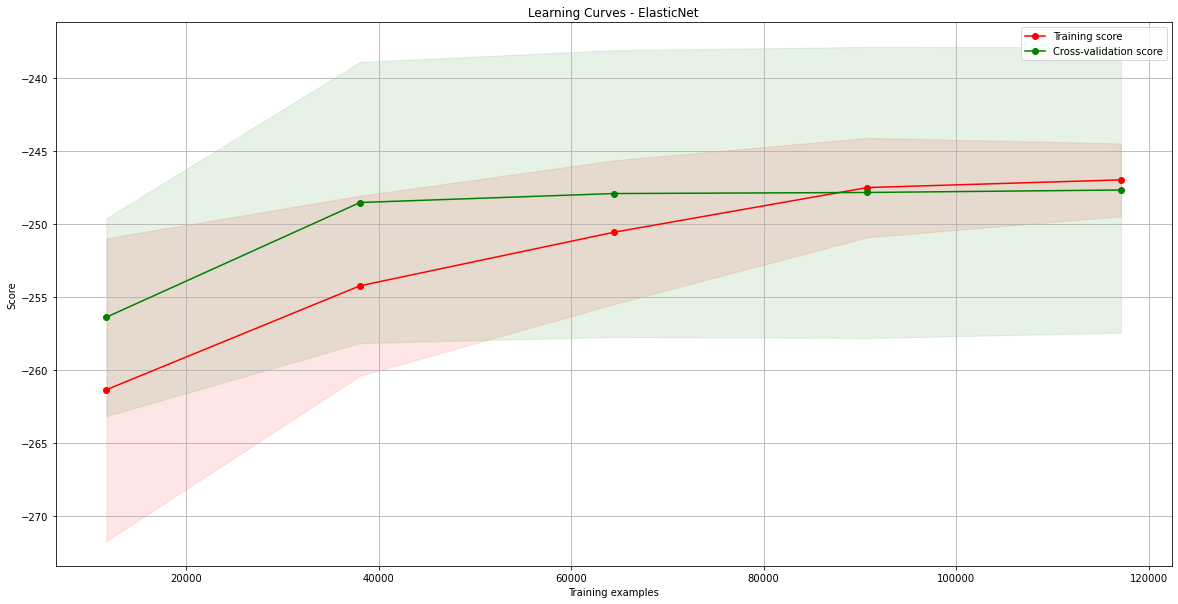

In [497]:
en_lc = ElasticNet(random_state=0)
title = "Learning Curves - ElasticNet"
plot_learning_curve(en_lc, title, x_train_split, y_train_split, cv=5, n_jobs=-1)

Curva de aprendizado não indica overfitting, parece coerente com aprendizado real.

<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

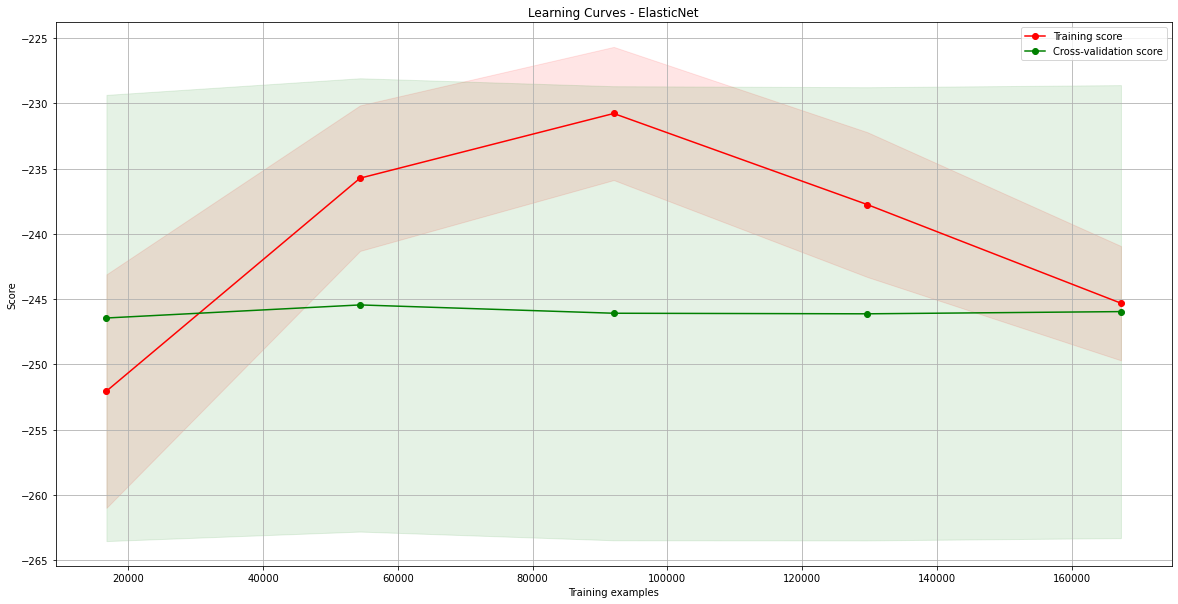

In [505]:
en_lc = ElasticNet(random_state=0)
title = "Learning Curves - ElasticNet"
plot_learning_curve(en_lc, title, x_train_total, y_train_total, cv=5, n_jobs=-1)

Não sei o que ta acontecendo aqui kkkkkkkk

# Dividindo por Canal

Treinaremos um modelo para cada Canal de venda, assumindo que o comportamento dos clientes em diferentes canais é distinto dos demais.

In [460]:
canais = df['CANAL'].unique()
# define listas para receber os dados separados por canal
x_train_aux = [[] for x in range(len(canais))]
y_train_aux = [[] for x in range(len(canais))]
x_test_aux = [[] for x in range(len(canais))]

# divide o dataset por canal
for i, canal in enumerate(canais):
    df_aux = df[df['CANAL']==canal]
    x_train_aux[i], y_train_aux[i], x_test_aux[i] = transform_df(df_aux)

In [469]:
for i,canal in zip(range(5),canais): 
    print(canal, x_train_aux[i].shape)

FIS (176452, 15)
TELEVENDAS (5764, 15)
ECM (36846, 15)
WHATSAPP (2921, 15)
IFOOD (1247, 15)


In [470]:
# cria lista de modelos
modelos = [ElasticNet(random_state=0) for x in range(len(canais))]
# lista para receber as predições
preds = [[] for x in range(len(canais))]

In [471]:
# treina e faz a previsão para cada modelo
for i, modelo in enumerate(modelos):
    preds[i] = modelo.fit(x_train_aux[i], y_train_aux[i]).predict(x_test_aux[i])

0
1


C:\Users\ticom\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93772119.45821151, tolerance: 87201.48240262675
  model = cd_fast.enet_coordinate_descent(


2
3
4


C:\Users\ticom\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19784006.71365428, tolerance: 48474.092249639085
  model = cd_fast.enet_coordinate_descent(
C:\Users\ticom\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2740330.6864422634, tolerance: 6620.535482075572
  model = cd_fast.enet_coordinate_descent(


In [472]:
# cria lista para receber as previsões transformadas para dataframe
df_preds=[[] for x in range(5)]
for i, canal in enumerate(canais):
    df_preds[i] = pd.DataFrame(preds[i], index=x_test_aux[i].index)

# Join nas previsões dos diferentes canais
for prediction in df_preds:
     df_sub = df_sub.join(prediction,on='ID_CLIENTE', lsuffix='_sum', rsuffix='_TARGET')

# soma as previsões dos canais em uma coluna "FINAL"
df_sub['FINAL'] = df_sub.iloc[:,1:].sum(axis=1)
# drop nas previsões para ficar só a soma
df_sub.drop(list(df_sub.columns[1:-1]),axis=1,inplace=True)
# corrige o nome das colunas para submissão
df_sub.columns = ['ID_CLIENTE','VALOR']

In [503]:
# melhor score na public leaderboard
df_sub5 = pd.read_csv(r'C:\Users\ticom\VLabs\Submissions\best_score.csv')

# validação direta
score_dir = mean_squared_error(df_sub5,df_sub, squared=False)
print('Validação direta RMSE: ',score_dir)

Validação direta RMSE:  20.269829001834044


Pela validação a submissão não está muito diferente da melhor submissão no public leaderboard. Esse é um pontecial melhor modelo.

# Submissão

In [488]:
df_sub.to_csv(r'C:\Users\ticom\VLabs\Submissions\sub10.csv', index=False)